## 논의
또래지명과 자기보고의 데이터특성 차이로 적절한 비교방법 탐색이 필요함

보고방식|설명|최소|최대|
|------|---|---|---|
|또래지명|A가 다른 학생들로부터 지명받은 횟수|0|학생수|
|리커트|타인 또는 본인에게 1-5점으로 평가한 점수|1|5|

In [208]:
# 또래 지명 응답값 불러오기
import pandas as pd
import requests
from io import BytesIO
url = "https://github.com/Byumin/peer/raw/refs/heads/scoring/point_df.xlsx"
response = requests.get(url)
response.raise_for_status()
point_df = pd.read_excel(BytesIO(response.content))
point_df

,point_item_no,student_designation,student_nomination
0,PN1,student1,student15
1,PN1,student2,student6
2,PN1,student3,student18
3,PN1,student4,student7
4,PN1,student4,student12
...,...,...,...
457,PN19,student16,student1
458,PN19,student17,student6
459,PN19,student18,student13
460,PN19,student19,student12


또래지명 결과 산출
* 지명수/학생수 = 비율 점수 산출

In [211]:
# 또래지명 비율 점수 산출 함수
# 문항값은 리스트로 전달, 학생명은 텍스트로 전달
# 0~1 비율
def point_ratio_score(point_df, item, name):
    if not item :
        return 0
    else :
        item='|'.join(item)
        temp_df=point_df[point_df['point_item_no'].str.contains(item)]
        score = round(len(temp_df[temp_df['student_nomination']==name])/len(temp_df['student_designation']),2)
    return score

In [213]:
item = ['PN2', 'PN3']
point_ratio_score(point_df, item, 'student14')

0.09

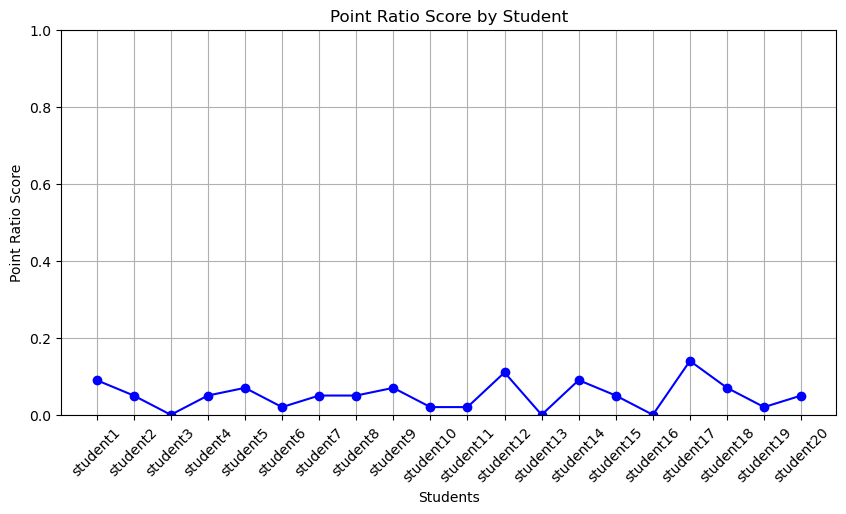

In [215]:
import matplotlib.pyplot as plt

# 학생 1부터 20까지 X축
# 비율 점수를 Y축
# 꺽은선 그래프 시각화
students = point_df['student_designation'].unique().tolist()
item = ['PN2', 'PN3']
scores = [point_ratio_score(point_df, item, student) for student in students]

# 꺾은선 그래프
plt.figure(figsize=(10, 5))
plt.plot(students, scores, marker='o', linestyle='-', color='b', label="Point Ratio Score")
plt.xlabel("Students")
plt.ylabel("Point Ratio Score")
plt.title("Point Ratio Score by Student")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.show()

# 상대적 위치가 아닌 절대적 위치를 확인할 수 있는 결과라서
# 그래프가 전반적으로 플랫하게 나타남

또래지명 결과 산출
* 지명수 평균과 표준편차 활용하여 Z점수 산출

In [12]:
# 또래지명 Z 점수 산출 함수
# 문항값은 리스트로 전달, 학생명은 텍스트로 전달
# 평균=0, 표준편차=1 표준화
import numpy as np
from scipy.stats import zscore

def point_z_score(point_df, item, name):
    if not item :
        return 0
    else :
        item='|'.join(item)
        temp_df=point_df[point_df['point_item_no'].str.contains(item)]
        temp_list = []
        for x in temp_df['student_designation'].unique() :
            count=temp_df['student_nomination'].value_counts().get(x,0)
            temp_list.append(count)
        z_score_list = zscore(temp_list)
        z_score = z_score_list[np.where(temp_df['student_designation'].unique()==name)[0][0]]
        return z_score

In [14]:
item = ['PN2', 'PN3']
point_z_score(point_df, item, 'student16')

3.2539568672798427

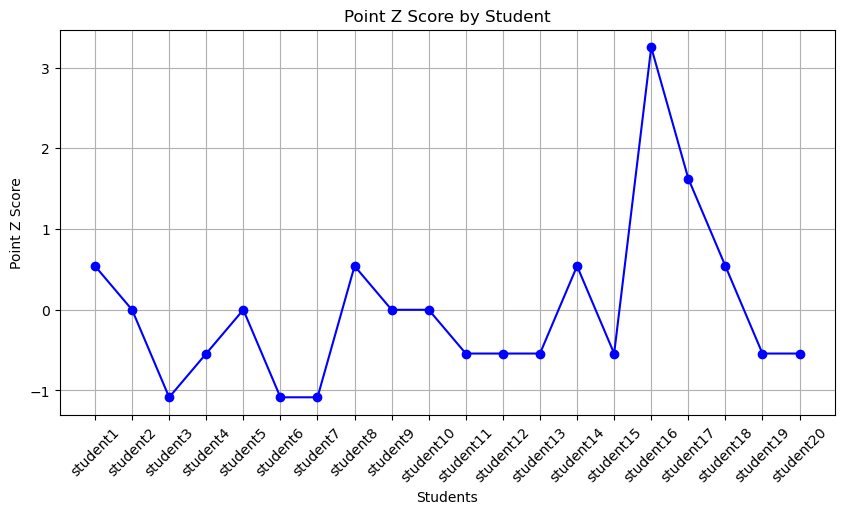

In [60]:
# 학생 1부터 20까지 X축
# 비율 점수를 Y축
# 꺽은선 그래프 시각화
students = point_df['student_designation'].unique().tolist()
item = ['PN2', 'PN3']
scores = [point_z_score(point_df, item, student) for student in students]

# 꺾은선 그래프
plt.figure(figsize=(10, 5))
plt.plot(students, scores, marker='o', linestyle='-', color='b', label="Point Z Score")
plt.xlabel("Students")
plt.ylabel("Point Z Score")
plt.title("Point Z Score by Student")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 상대적인 위치라서 학생들의 값의 절대적 차이에 비해 드라마틱하게 나타남
# 그러나 범위가 고정되어 있지 않기때문에 y축이 동적임
# 현장 데이터가 어떠한지 모르겠으나 0 지명인 아동이 많다면 평균은 0에 가까울 것
# 0이 대부분이고 양적인 변화만 있는 데이터일텐데.... 어떤 점수 산출이 효과적일지...?

또래지명 결과 산출
* Z점수 활용해 5가지 수준 산출 및 넘버링

백분위|Z-score 범위|넘버링|수준|
|------|---|---|---|
|상위 20% (80-100%)|+0.84<=Z|5|매우 높음|
|60-80%|+0.25<=Z<+0.84|4|높음|
|40-60%|-0.25<=Z<+0.25|3|보통|
|20-40%|-0.84<=Z<-0.25|2|낮음|
|하위 20% (0-20%)|Z<-0.84|1|매우 낮음|

In [32]:
# 또래지명 Z 점수에 따른 수준 분류 함수
# 문항값은 리스트로 전달, 학생명은 텍스트로 전달
# Z점수의 백분위에 따라 5가지 분류
# 일반적으로 Z 점수에 따른 백분위 분류방법으로 산출
import numpy as np
from scipy.stats import zscore

def covert_z_level(z_score_list) :
    level_list = np.where(z_score_list >= 0.84, 5,
                          np.where(z_score_list >= 0.25, 4,
                                   np.where(z_score_list >= -0.25, 3,
                                            np.where(z_score_list >= -0.84, 2,1))))
    return level_list

def point_z_level_score(point_df, item, name):
    if not item :
        return 0
    else :
        item='|'.join(item)
        temp_df=point_df[point_df['point_item_no'].str.contains(item)]
        temp_list = []
        for x in temp_df['student_designation'].unique() :
            count=temp_df['student_nomination'].value_counts().get(x,0)
            temp_list.append(count)
        z_score_list = zscore(temp_list)
        level_list = covert_z_level(z_score_list)
        level = level_list[np.where(temp_df['student_designation'].unique()==name)[0][0]]
        return level

In [34]:
item = ['PN2', 'PN3']
point_z_level_score(point_df, item, 'student16')

5

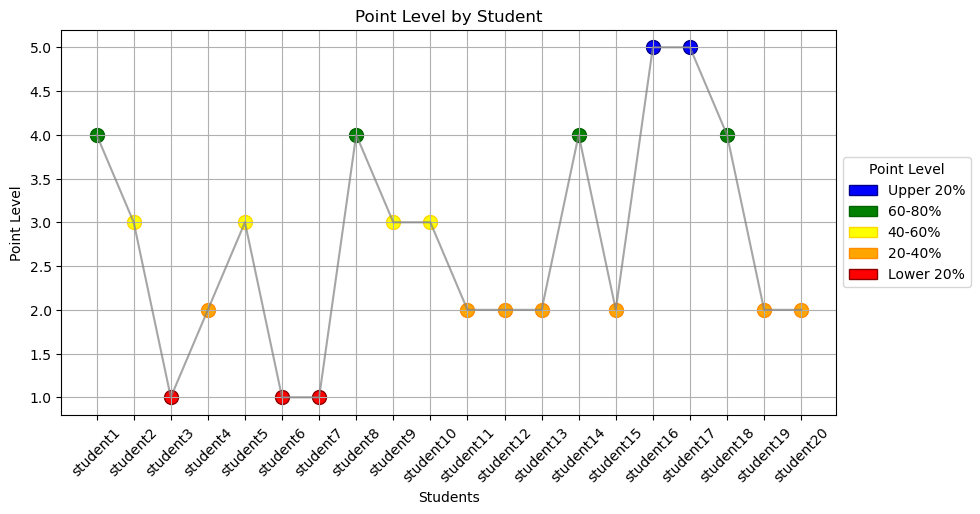

In [86]:
# 학생 1부터 20까지 X축
# 비율 점수를 Y축
# 꺽은선 그래프 시각화
students = point_df['student_designation'].unique().tolist()
item = ['PN2', 'PN3']
scores = [point_z_level_score(point_df, item, student) for student in students]

# 점수에 따른 색상 맵핑
inner_colors = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'blue'}
border_colors = {1: 'darkred', 2: 'darkorange', 3: 'gold', 4: 'darkgreen', 5: 'darkblue'}

# 꺾은선 그래프
plt.figure(figsize=(10, 5))
plt.plot(students, scores, linestyle='-', color='gray', alpha=0.7, label="Point Level Score")

# 점 개별 색상 적용
for i, student in enumerate(students):
    plt.scatter(student, scores[i], s=100,
                facecolors=inner_colors[scores[i]],
                edgecolors=border_colors[scores[i]],
                linewidth=1, marker='o')

plt.xlabel("Students")
plt.ylabel("Point Level")
plt.title("Point Level by Student")
plt.xticks(rotation=45)
plt.grid(True)

# 수동 범례 추가
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='blue', edgecolor='darkblue', label="Upper 20%"),
    Patch(facecolor='green', edgecolor='darkgreen', label="60-80%"),
    Patch(facecolor='yellow', edgecolor='gold', label="40-60%"),
    Patch(facecolor='orange', edgecolor='darkorange', label="20-40%"),
    Patch(facecolor='red', edgecolor='darkred', label="Lower 20%")
]

plt.legend(handles=legend_elements, loc="center left", title="Point Level", bbox_to_anchor=(1, 0.5))

plt.show()

# y축 범위가 1에서 5점이기 때문에 정적
# 드라마틱하게 산출

또래지명 결과 산출
* 집단 내 백분위로 점수 산출

In [174]:
# 집단 내 백분위로 점수 산출
# 문항값은 리스트로 전달, 학생명은 텍스트로 전달
import numpy as np
from scipy.stats import rankdata

def per_value(values):
    ranks = rankdata(values, method="average")
    per_list = (ranks - 1) / (len(values) - 1) * 100
    return per_list

def point_per_score(point_df, item, name):
    if not item :
        return 0
    else :
        item='|'.join(item)
        temp_df=point_df[point_df['point_item_no'].str.contains(item)]
        temp_list = []
        for x in temp_df['student_designation'].unique() :
            count=temp_df['student_nomination'].value_counts().get(x,0)
            temp_list.append(count)
            temp_arr = np.array(temp_list)
        per_list = np.round(per_value(temp_arr), 2)
        per = per_list[np.where(temp_df['student_designation'].unique()==name)[0][0]]
        return per

In [176]:
item = ['PN2', 'PN3']
point_per_score(point_df, item, 'student16')

100.0

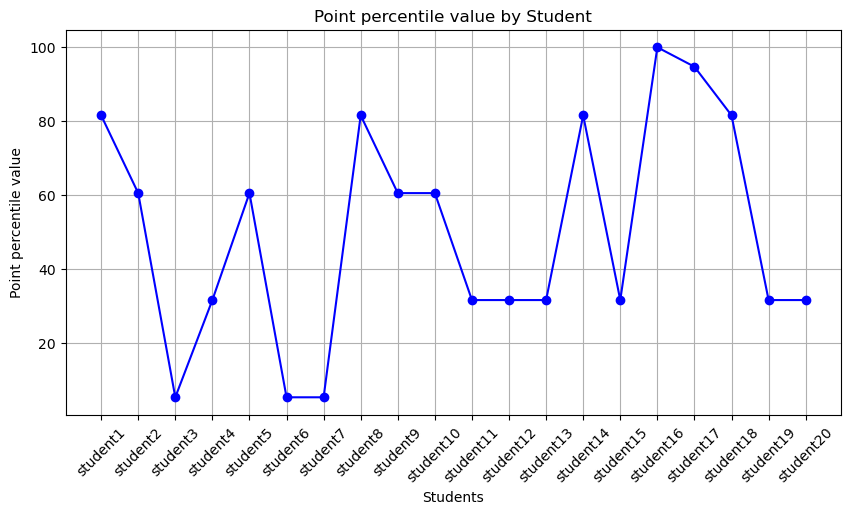

In [180]:
# 학생 1부터 20까지 X축
# 비율 점수를 Y축
# 꺽은선 그래프 시각화
students = point_df['student_designation'].unique().tolist()
item = ['PN2', 'PN3']
scores = [point_per_score(point_df, item, student) for student in students]

# 꺾은선 그래프
plt.figure(figsize=(10, 5))
plt.plot(students, scores, marker='o', linestyle='-', color='b', label="Point percentile value")
plt.xlabel("Students")
plt.ylabel("Point percentile value")
plt.title("Point percentile value by Student")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

또래지명 결과 산출
* 집단 내 백분위로 5 수준으로 구분하여 산출

백분위 범위|넘버링|수준|
|----------|------|----|
|상위 20% (80-100%)|5|매우 높음|
|60-80%|4|높음|
|40-60%|3|보통|
|20-40%|2|낮음|
|하위 20% (0-20%)|1|매우 낮음|

In [188]:
# 집단내 백분위에 따른 수준 분류 함수
# 문항값은 리스트로 전달, 학생명은 텍스트로 전달
# 백분위에 따라 5가지 분류
# 일반적으로 수준별 20%씩 분류하여 산출
import numpy as np
from scipy.stats import rankdata

def covert_p_level(per_list) :
    level_list = np.where(per_list >= 80, 5,
                          np.where(per_list >= 60, 4,
                                   np.where(per_list >= 40, 3,
                                            np.where(per_list >= 20, 2,1))))
    return level_list

def per_value(values):
    ranks = rankdata(values, method="average")
    per_list = (ranks - 1) / (len(values) - 1) * 100
    return per_list

def point_per_level_score(point_df, item, name):
    if not item :
        return 0
    else :
        item='|'.join(item)
        temp_df=point_df[point_df['point_item_no'].str.contains(item)]
        temp_list = []
        for x in temp_df['student_designation'].unique() :
            count=temp_df['student_nomination'].value_counts().get(x,0)
            temp_list.append(count)
            temp_arr = np.array(temp_list)
        per_list = np.round(per_value(temp_arr), 2)
        level_list = covert_p_level(per_list)
        level = level_list[np.where(temp_df['student_designation'].unique()==name)[0][0]]
        return level

In [190]:
item = ['PN2', 'PN3']
point_per_level_score(point_df, item, 'student16')

5

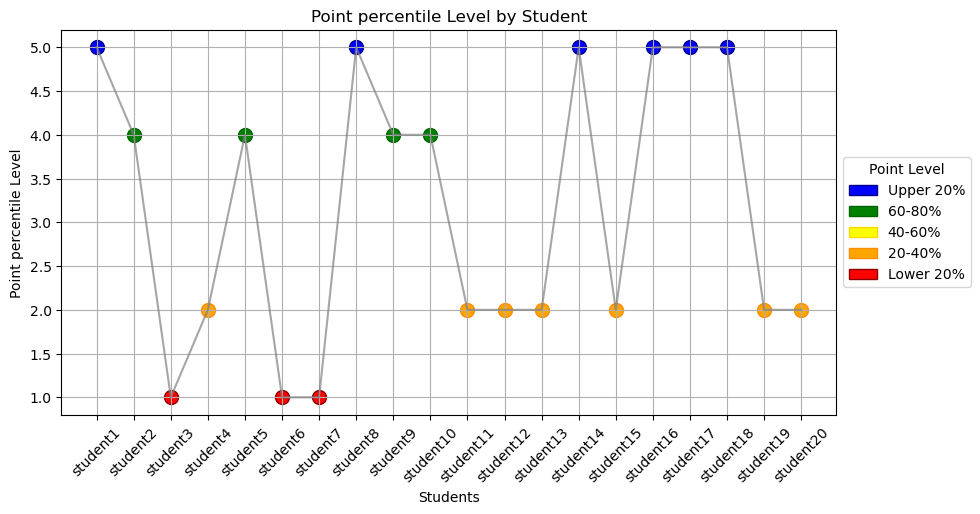

In [194]:
# 학생 1부터 20까지 X축
# 비율 점수를 Y축
# 꺽은선 그래프 시각화
students = point_df['student_designation'].unique().tolist()
item = ['PN2', 'PN3']
scores = [point_per_level_score(point_df, item, student) for student in students]

# 점수에 따른 색상 맵핑
inner_colors = {1: 'red', 2: 'orange', 3: 'yellow', 4: 'green', 5: 'blue'}
border_colors = {1: 'darkred', 2: 'darkorange', 3: 'gold', 4: 'darkgreen', 5: 'darkblue'}

# 꺾은선 그래프
plt.figure(figsize=(10, 5))
plt.plot(students, scores, linestyle='-', color='gray', alpha=0.7, label="Point Level Score")

# 점 개별 색상 적용
for i, student in enumerate(students):
    plt.scatter(student, scores[i], s=100,
                facecolors=inner_colors[scores[i]],
                edgecolors=border_colors[scores[i]],
                linewidth=1, marker='o')

plt.xlabel("Students")
plt.ylabel("Point percentile Level")
plt.title("Point percentile Level by Student")
plt.xticks(rotation=45)
plt.grid(True)

# 수동 범례 추가
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor='blue', edgecolor='darkblue', label="Upper 20%"),
    Patch(facecolor='green', edgecolor='darkgreen', label="60-80%"),
    Patch(facecolor='yellow', edgecolor='gold', label="40-60%"),
    Patch(facecolor='orange', edgecolor='darkorange', label="20-40%"),
    Patch(facecolor='red', edgecolor='darkred', label="Lower 20%")
]

plt.legend(handles=legend_elements, loc="center left", title="Point Level", bbox_to_anchor=(1, 0.5))

plt.show()